# Homework 3
### 01.01.2021
### Akarun Ayça Ersoy

## Penalized Regression Approaches to Electricity Consumption Data
The dataset for this homework comes from the hourly electricity consumption series made publicly available at https://seffaflik.epias.com.tr/transparency/. The dataset is split into a 'training' set and 'test' set. Using the training set we construct a model and use it to predict the test set. The training set includes hourly data from 01.01.2016 to 31.10.2020. The test dataset includes data from 01.11.2020 to 30.11.2020.
The aim of this project is to accurately predict the hourly electricity consumption using the available electricity data from 2 days and 7 days ago. 

In [11]:
#Setting the working directory
setwd('/Users/user/Documents/AYCADoc/BOUN/IE582')
library(data.table)
library(dplyr)
library(ggplot2)
library(glmnet)

#Reading the raw data and renaming the consumption column for easier access
rawData <- fread('dataforHW3.csv')
colnames(rawData)[3] <- "Consumption"
#Reformatting the consumption column from character to numeric type
rawData$Consumption <- gsub(",", "", rawData$Consumption)
rawData$Consumption <- as.numeric(rawData$Consumption)
endPt <- dim(rawData)[1]
Hour <- rep(0:23, times=(endPt/24))
rawData$Hour <- Hour

## Task A
In this first task, we take a naive approach to the prediction problem. The naive approach is to just use the daily values from 168 hours ago (7x24) and 48 hours ago (2x24). The metric for comparison is mean absolute percentage error (MAPE).

In [2]:
#PART A
ind <- which(rawData$Date == '01.11.2020')[1]
testData <- rawData[ind:endPt]
testData <- cbind(testData, 
                   "lag48" = rawData$Consumption[(ind-48):(endPt-48)],
                   "lag168" = rawData$Consumption[(ind-168):(endPt-168)])

mape_48 <- mean(abs((testData$Consumption-testData$lag48)/testData$Consumption)) * 100
mape_168 <- mean(abs((testData$Consumption-testData$lag168)/testData$Consumption)) * 100
print(paste("Mape for lag48 is", format(round(mape_48, 2), nsmall = 2)))
print(paste("Mape for lag168 is", format(round(mape_168, 2), nsmall = 2)))

[1] "Mape for lag48 is 7.79"
[1] "Mape for lag168 is 3.45"


## Task B
From the first task, we have observed that lag48 and lag168 serve as moderately accurate predictors for the current electricity consumption. In this section, we will be constructing a linear regression model using these two features (lag48 and lag 168). 
First we create a training set and then use the 'lm' function to build the model. These coefficients are then used to predict the electricity consumptions for the test set. The mean absolute percentage error is reported. The plot shows the relationship between the predictions and the actual consumption values.

In [3]:
#Constructing the training data (excluding first 168 to be able to have a lag)
trainData <- rawData[169:(ind-1)]
trainData <- cbind(trainData, 
                   "lag48" = rawData$Consumption[(169-48):((ind-1)-48)],
                   "lag168" = rawData$Consumption[(169-168):((ind-1)-168)])
#Fitting the linear regression model
fit_lreg <- lm(Consumption ~ lag48 + lag168, data=trainData)
summary(fit_lreg)

#Making predictions for the consumption of the test data
predicted <- predict(fit_lreg,testData)


Call:
lm(formula = Consumption ~ lag48 + lag168, data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-25242.2   -984.2     -0.5   1016.9  16102.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.574e+03  8.353e+01   18.84   <2e-16 ***
lag48       3.084e-01  3.096e-03   99.60   <2e-16 ***
lag168      6.435e-01  3.094e-03  208.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2392 on 42213 degrees of freedom
Multiple R-squared:  0.7753,	Adjusted R-squared:  0.7753 
F-statistic: 7.281e+04 on 2 and 42213 DF,  p-value: < 2.2e-16


[1] "Mape for linear fit using lag48 and lag168 is 4.12"


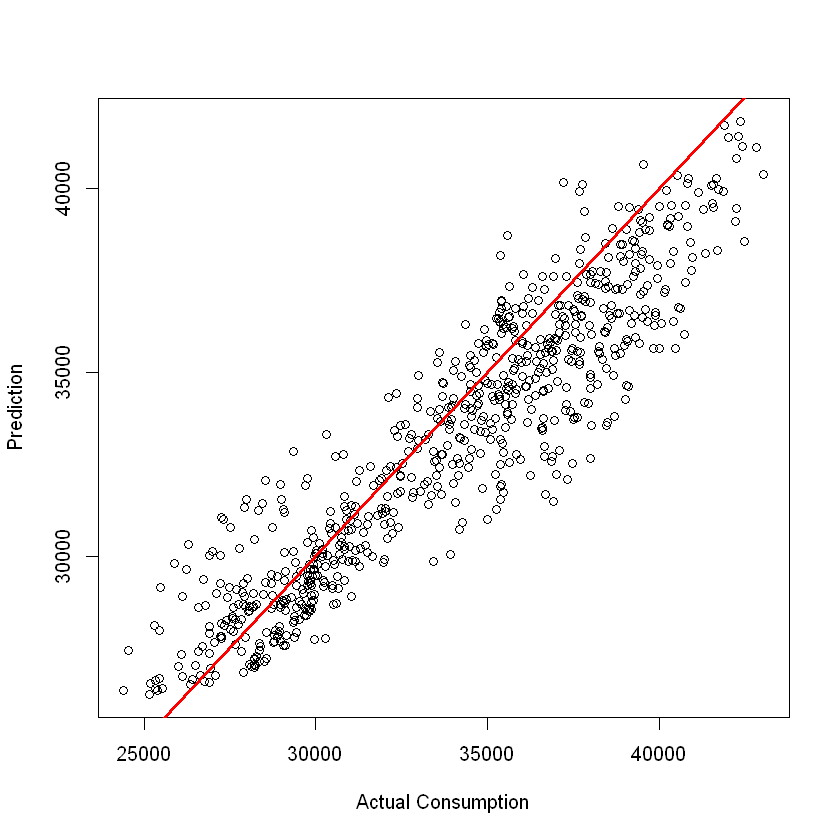

In [4]:
mape_B <- mean(abs((testData$Consumption-predicted)/testData$Consumption))*100
print(paste("Mape for linear fit using lag48 and lag168 is", format(round(mape_B, 2), nsmall = 2)))

plot(testData$Consumption,predicted, xlab="Actual Consumption", ylab="Prediction")
abline(a=0,b=1,col=2, lwd=3)

### Comments
The MAPE value shows that the linear model actual does a **worse** job predicting the actual consumptions than simply usind the values from a week ago (lag168). A possible shortcoming of this approach is that, it considers all of the consumptions for different hours as a part of the same model. This issue will be addressed in the next section.

## Task C
In the previous sections, we had considered each hour to be part of the same model. For this task, we will be building separate models for the prediction of each hour. Each hour will be predicted by the corresponding hours from 2 days and 7 days ago. This might be a better approach since the electricity consumption at night is drastically different than morning electricity consumption.

[1] "Average MAPE of all hours is 4.25"


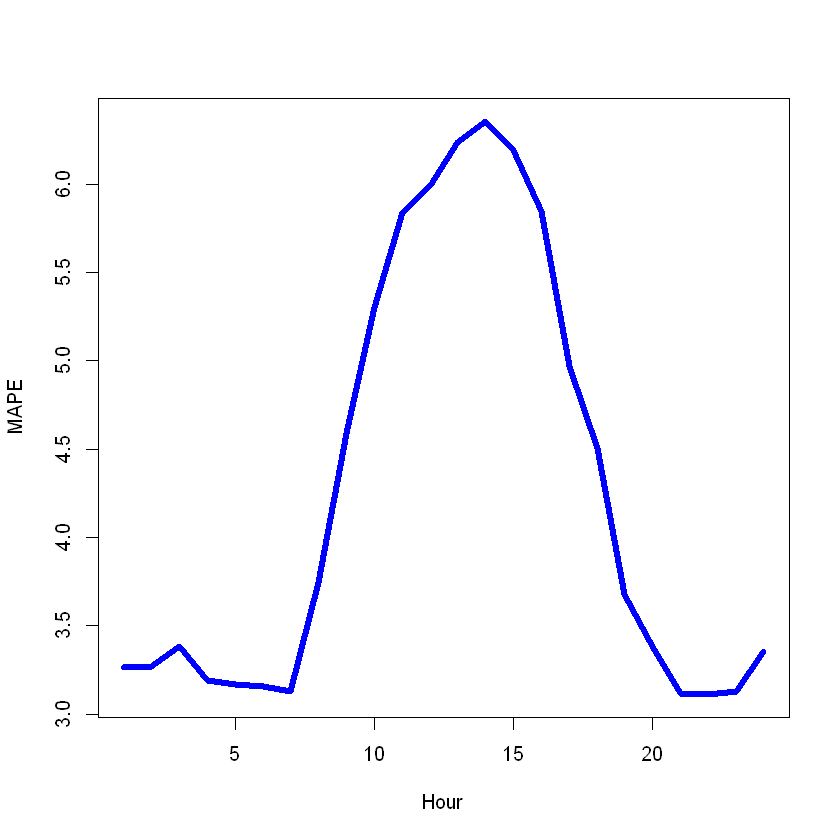

In [5]:
predTime <- matrix(0,720,24)
mape_C <- rep(0,times=24)
partC_coeff <- matrix(0,24,3)
for(i in 1:24){
    trainTime <- filter(trainData, Hour==(i-1))
    fit_C <- lm(Consumption ~ lag48 + lag168, data=trainTime)
    partC_coeff[i,]<-fit_C$coefficients
    #print(summary(fit_C))
    testTime <- filter(testData, Hour==(i-1))
    predTime <- predict(fit_C,testTime)
    mape_C[i] <- mean(abs((testTime$Consumption-predTime)/testTime$Consumption))*100
}
print(paste("Average MAPE of all hours is", format(round(mean(mape_C), 2), nsmall = 2)))
hour_range <- 1:24
plot(hour_range,mape_C, type="l", col="blue", lwd=5, xlab="Hour", ylab="MAPE")

In [6]:
#This is only the summary of the linear regression for the 23rd hour
print(summary(fit_C))
colnames(partC_coeff)<- c("Intercept", "lag48","lag168")
rownames(partC_coeff) <- c(paste("Hour",0:23))
partC_coeff <- as.table(partC_coeff)
print(partC_coeff)


Call:
lm(formula = Consumption ~ lag48 + lag168, data = trainTime)

Residuals:
    Min      1Q  Median      3Q     Max 
-9571.0  -852.5    54.6   918.8  7916.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.541e+03  4.860e+02   5.229  1.9e-07 ***
lag48       4.511e-01  1.694e-02  26.621  < 2e-16 ***
lag168      4.720e-01  1.693e-02  27.882  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1738 on 1756 degrees of freedom
Multiple R-squared:  0.6932,	Adjusted R-squared:  0.6929 
F-statistic:  1984 on 2 and 1756 DF,  p-value: < 2.2e-16

           Intercept        lag48       lag168
Hour 0  2191.3207957    0.4868831    0.4428359
Hour 1  2120.4519856    0.4919552    0.4364232
Hour 2  2831.1373922    0.4753444    0.4252267
Hour 3  2229.1366797    0.4927967    0.4269401
Hour 4  2204.2581510    0.4746859    0.4449727
Hour 5  2225.0314361    0.4398487    0.4784599
Hour 6  2126.9463108    0.3759635    

### Comments
The plot above shows each of the MAPEs for each hour. The predictions for the night-time hours appear to be more accurate than the day-time hours (7-21). This might be because nightly electricity usage is more consistent compared to daytime usage, which differs drastically between days. Also, when we look at the coefficients for lag48 and lag168 they are very similar for the night-hours (1-6) but lag168 is greater for day-hours. This is probably because daily consumption is highly dependant on the day of the week. 

## Task D
In the previous section we only considered the corresponding hours from the previous days - what if all of them are important? In this section, each of the hours from lag48 and lag168 will be treated as separate predictors. In order to do this, we first convert our dataset into the wide format. Now, we have 48 predictors (in the previous section we had 2 predictors). 
However, we also know that this is probably too many predictors to include in a model. Therefore, we will be using a penalized regression approach that sets some of the coefficients to zero. We are performing cross-validation to obtain the best lambda for lasso. 

In [7]:
#Train Data
wideData <- reshape(trainData, idvar = "Date", timevar = "Hour", drop=c("Consumption"),direction = "wide")
wideData2 <- reshape(trainData, idvar = "Date", timevar = "Hour", drop=c("lag48","lag168"),direction = "wide")
wideData <- cbind(wideData,wideData2[,2:25])

#Test Data
wideTest <- reshape(testData, idvar = "Date", timevar = "Hour", drop=c("Consumption"),direction = "wide")
wideTest2 <- reshape(testData, idvar = "Date", timevar = "Hour", drop=c("lag48","lag168"),direction = "wide")
wideTest <- cbind(wideTest,wideTest2[,2:25])

[1] "Average MAPE of all hours is 2.42"


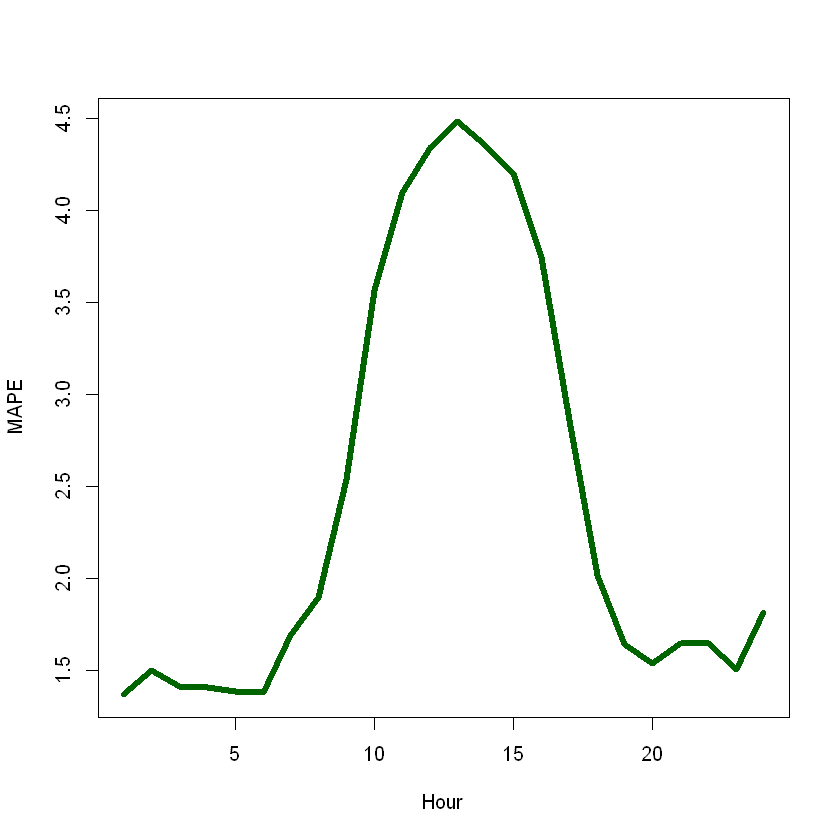

In [8]:
set.seed(601)
mape_D <- rep(0,times=24)
for(i in 1:24){
    colInd <- 49+i
    cvfit = cv.glmnet(as.matrix(wideData[,2:49]),as.numeric(as.matrix(wideData[,..colInd])),family="gaussian")
    assign(paste("cvfit",i,sep="_"),cvfit)
    predD <- predict(cvfit, as.matrix(wideTest[,2:49]),s='lambda.min')
    actual <- as.matrix(wideTest[,..colInd])
    mape_D[i] <- mean(abs((actual-predD)/actual))*100
}
print(paste("Average MAPE of all hours is", format(round(mean(mape_D), 2), nsmall = 2)))
plot(hour_range,mape_D, type="l", col="darkgreen", lwd=5, xlab="Hour", ylab="MAPE")

In [9]:
#This is only for the 23rd hour
print(cvfit_23)
coef(cvfit_23)


Call:  cv.glmnet(x = as.matrix(wideData[, 2:49]), y = as.numeric(as.matrix(wideData[,      ..colInd])), family = "gaussian") 

Measure: Mean-Squared Error 

    Lambda Measure    SE Nonzero
min  4.294 1824615 96504      25
1se  9.039 1910959 90470      21


49 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  5.371980e+03
lag48.0     -4.282121e-02
lag168.0     .           
lag48.1     -2.232751e-01
lag168.1     .           
lag48.2      .           
lag168.2    -8.984917e-03
lag48.3      .           
lag168.3     .           
lag48.4      .           
lag168.4    -2.053642e-01
lag48.5      2.228750e-01
lag168.5    -4.240588e-01
lag48.6      8.790075e-05
lag168.6     .           
lag48.7      .           
lag168.7     3.266503e-01
lag48.8     -5.839176e-03
lag168.8     1.812417e-01
lag48.9     -5.270935e-01
lag168.9     .           
lag48.10     .           
lag168.10    .           
lag48.11     .           
lag168.11    .           
lag48.12     .           
lag168.12   -2.026698e-02
lag48.13     1.456479e-01
lag168.13    .           
lag48.14     .           
lag168.14    .           
lag48.15     .           
lag168.15    .           
lag48.16     .           
lag168.16    1.360467e-01
lag48.17     .        

### Comments
The plot again shows the different MAPEs for different hours. Similar to the previous one, the predictions are more accurate for night-time hours. However, all of them have improved compared to linear regression approach.
Below that we have the penalized regression properties for the 23rd hour. Again, I have only provided an example for 1 hour as they are all similar. The minimum error is obtained using a lambda of 4.294 and it uses 25 nonzero predictors. 1 standard error away from the minimum we are using 21 nonzero predictors. I have also given the coefficients for the fit for the 23rd hour. The first thing I notice is that some of them are negative, this means that that property inversely affects the current electricity consumption.

## Task F
I finally present the boxplots of the MAPEs for tasks C and D. 

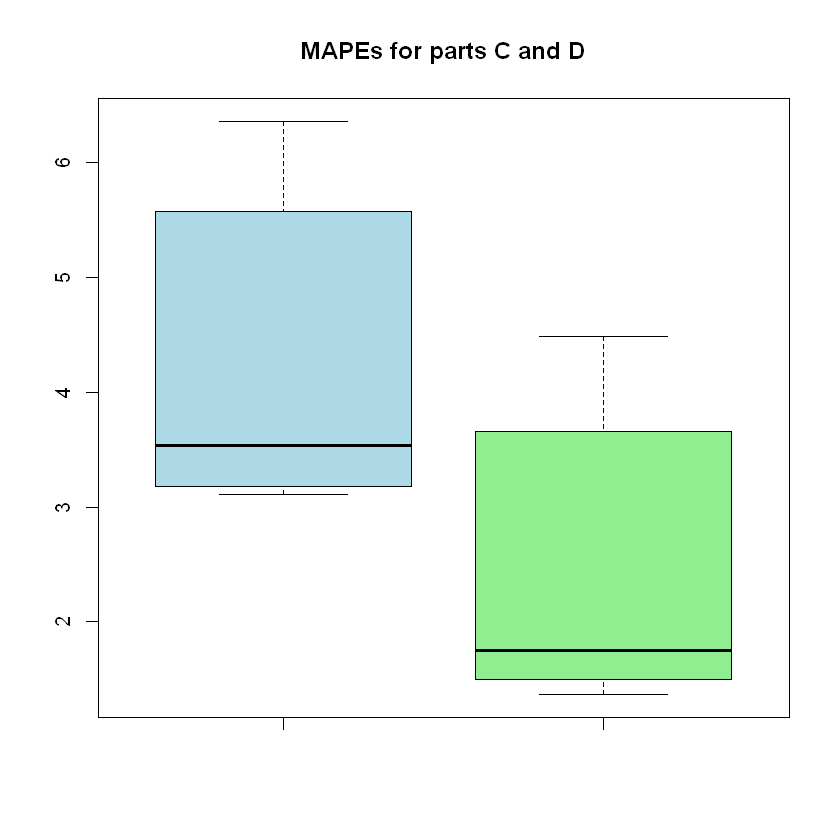

In [10]:
boxplot(mape_C,mape_D, main="MAPEs for parts C and D", col=c("lightblue","lightgreen"))

### Comments
It's possible to see how much the mean absolute percentage errors have improved using the penalized regression approach. The mean of the results obtained by Lasso (green) are less than mean of the results obtained by linear regression.